In [1]:
# load smaller sample of UC Merced dataset, and run the example CIFAR network

### PREAMBLE ################################################################
# allows the images to be displayed in the jupyter notebook
%matplotlib inline

# torch and torchvision related
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# image library
from PIL import Image

# some numeric stuff
import numpy as np
import random
import matplotlib.pyplot as plt

# file input/output libraries
import fnmatch
import os

# datetime
import datetime
now = datetime.datetime.now()

### OPTIONS #################################################################
# may want to later set from command line

# set random seed value
seedVal = 123;

# at which epochs to record training/validation error
epochsConsidered = [5, 10, 25, 50, 100, 150, 200, 250]
saveNetEpochsConsidered = True;

### PATHS ###################################################################

pathTrain = './data/UCMerced_8ClassesTrainValTest/train/'
pathVal = './data/UCMerced_8ClassesTrainValTest/val/'
pathOutput = './output/'

### FUNCTIONS ###############################################################

# function to compute the percentage accuracy in categorizing images
def computeAccuracy(net, dataSubset):
    correct = 0
    total = 0
    # don't want batches, want to compute over the whole dataset
    dataSubsetLoader = torch.utils.data.DataLoader(dataSubset, num_workers=2)
    for data in dataSubsetLoader:
        images, labels = data  
        outputs = net(Variable(images))
        print(outputs)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()

    percentAccuracy = 100 * correct / total
    print('Accuracy of the network is: %d %%' % (
        percentAccuracy))
    
    return(percentAccuracy)

In [2]:
# ### CONVERT IMAGES FROM .tif TO .png ########################################
# # ugly code, should make function rather than copy the same lines of code
# # for Train and Val, as can easily make mistakes

# classes = ['beach', 'forest', 'freeway', 'mediumresidential','agricultural', 'airplane', 'baseballdiamond','buildings']

# for k in range(0,8): ### CAS: change to range(0,8)
#     allTrainFiles = fnmatch.filter(os.listdir(pathTrain+classes[k]), '*.tif');
#     allValFiles = fnmatch.filter(os.listdir(pathVal+classes[k]), '*.tif');
#     print(k)
#     print(allTrainFiles)
#     for j in range(0,len(allTrainFiles)):
#             img = Image.open(pathTrain+classes[k]+'/'+allTrainFiles[j])
#             newName = os.path.splitext(pathTrain+classes[k]+'/'+allTrainFiles[j])[0]+'.png'
#             img.save(newName)
#     for j in range(0,len(allValFiles)):
#             img = Image.open(pathVal+classes[k]+'/'+allValFiles[j])
#             newName = os.path.splitext(pathVal+classes[k]+'/'+allValFiles[j])[0]+'.png'
#             img.save(newName)

In [3]:
# write what the transforms should be
# From website: Normalize an tensor image with mean and standard deviation. 
# Given mean: (M1,...,Mn)  and std: (S1,..,Sn) for n channels, this transform 
# will normalize each channel of the input
# for some reason resize has to come before ToTensor
transform = transforms.Compose( #lookup transforms.compose
    [transforms.Resize(size=32),
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the train and val dataset
#I switch from 4 to 10 on batch_size for both valset and trainsettrainset
trainset = datasets.ImageFolder(root=pathTrain,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,shuffle=True, num_workers=2)

valset = datasets.ImageFolder(root=pathVal, transform=transform)
valloader = torch.utils.data.DataLoader(valset, shuffle=True, num_workers=2)

### CAC classes must be in alphabetical order
classes = ('beach', 'forest', 'freeway', 'mediumresidential','agricultural', 'airplane', 'baseballdiamond','buildings')
classes = sorted(classes) 
print(classes)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'forest', 'freeway', 'mediumresidential']


baseballdiamond airplane mediumresidential mediumresidential freeway agricultural freeway beach buildings mediumresidential


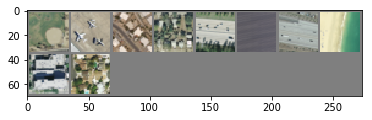

In [4]:
### PRINT IMAGES TO SCREEN TO VISUALIZE ####################################

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #lookup np.transpose
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

##Update
#print(images)
#print(labels) #Dont need to see this for now

# show images
imshow(tv.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [5]:
### NETWORK ARCHITECTURE #############################################

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x)) #vector of size 1 by 120 
        x = F.relu(self.fc2(x)) #vector of size 1 by 84
        x = self.fc3(x)
        return x

net = Net()

In [6]:
# print functions used in the network
net

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=8)
)

In [7]:
### SET UP TO DETERMINE BEST NUMBER OF EPOCHS (HYPERPARAMETER)
# for each epoch considered, find the training and validation Accuracy
# initialize vectors here
trainAccuracy = [0]*len(epochsConsidered)
valAccuracy = [0]*len(epochsConsidered)
count = 0;

In [8]:
### TRAIN NETWORK ######################################################

# set random seed
random.seed(seedVal);

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### CAS: increased the number of epochs get better result
for epoch in range(250):  # loop over the dataset multiple times 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        # print(loss.data)
        if i % 5 == 4:    # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/5)) #try divide by 5
            running_loss = 0.0
            
    # For selected epochs, compute training and val (see note)
    # acccuracy, and save the network so that it can be reloaded
    if (epoch+1) in epochsConsidered:
        trainAccuracy[count] = computeAccuracy(net, trainset)
        valAccuracy[count] = computeAccuracy(net, valset)
        count = count + 1
        # save networks at the different epochs, to later load
        if (saveNetEpochsConsidered):
            saveFilename = str(now.strftime("%Y-%m-%d")) + ('Original%s_epochs.pth' % (epoch+1))
            savePath = os.path.join(pathOutput, 'networks', saveFilename)
            torch.save(net.cpu().state_dict(), savePath)
        
print('Finished Training')

[1,     5] loss: 2.071
[1,    10] loss: 2.074
[1,    15] loss: 2.085
[1,    20] loss: 2.076
[1,    25] loss: 2.094
[1,    30] loss: 2.082
[1,    35] loss: 2.084
[1,    40] loss: 2.077
[1,    45] loss: 2.071
[1,    50] loss: 2.075
[1,    55] loss: 2.079
[1,    60] loss: 2.083
[2,     5] loss: 2.071
[2,    10] loss: 2.063
[2,    15] loss: 2.074
[2,    20] loss: 2.084
[2,    25] loss: 2.073
[2,    30] loss: 2.083
[2,    35] loss: 2.078
[2,    40] loss: 2.078
[2,    45] loss: 2.075
[2,    50] loss: 2.083
[2,    55] loss: 2.077
[2,    60] loss: 2.078
[3,     5] loss: 2.072
[3,    10] loss: 2.072
[3,    15] loss: 2.067
[3,    20] loss: 2.072
[3,    25] loss: 2.076
[3,    30] loss: 2.069
[3,    35] loss: 2.073
[3,    40] loss: 2.086
[3,    45] loss: 2.083
[3,    50] loss: 2.076
[3,    55] loss: 2.062
[3,    60] loss: 2.074
[4,     5] loss: 2.070
[4,    10] loss: 2.075
[4,    15] loss: 2.078
[4,    20] loss: 2.064
[4,    25] loss: 2.071
[4,    30] loss: 2.073
[4,    35] loss: 2.066
[4,    40] 


Variable containing:
1.00000e-02 *
 -6.8682  0.2994 -0.2705  0.8291 -4.4065 -5.6964  0.9005 -4.6525
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -6.1059  0.0761 -0.3429  0.8303 -4.9608 -4.2045  0.4197 -5.9526
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -5.3892 -1.1797 -0.5373  0.4372 -4.9753 -1.0863 -0.8380 -7.9858
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -5.3684 -1.1813 -0.5535  0.4778 -5.0416 -1.1747 -0.8320 -8.0661
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -5.3700 -0.9712 -0.4751  0.4525 -5.1073 -1.3978 -0.7587 -7.8722
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -6.0760 -0.3848 -0.3517  0.3863 -4.5498 -3.5663  0.0489 -6.3562
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -5.8351 -0.8295 -0.3337  0.2635 -4.7288 -2.9810 -0.2741 -6.9594
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -5.4200 -0.9016 -0.4485  0.5069 

Variable containing:
1.00000e-02 *
 -8.6934 -1.4749 -1.1237 -0.3874 -1.4795 -2.3214 -0.4599 -5.7579
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1037  0.0137 -0.0049 -0.0003  0.0060 -0.0949  0.0079  0.0026
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.6638  1.1295 -0.8743  0.3908 -2.5908 -6.9876  0.9975 -2.4086
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1073 -0.0019 -0.0038 -0.0096  0.0225 -0.0678  0.0010 -0.0112
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1033  0.0109 -0.0039 -0.0054  0.0229 -0.0832  0.0024  0.0143
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -9.0543 -0.5796 -0.3184 -1.0393  0.3521 -6.1283  0.0686 -1.5427
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.1451  0.1656 -0.3844  0.0156 -1.3803 -6.5181  0.1898 -2.4968
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.5541  0.6982 -0.7697 -1.1263 -0.2457 -7.8535  0.7999 -0.4032
[torch.FloatTe

Variable containing:
1.00000e-02 *
 -8.6477  0.1380  0.5111 -1.0108 -1.7587 -7.7630  1.1823 -1.5402
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.9228  1.0836  0.4765 -1.1752 -1.2088 -8.3800  1.7146  0.9008
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.5994  0.2066 -1.0457  0.7208 -2.6002 -6.4088  0.7688 -3.5079
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -7.4399  0.0332 -1.0774  1.1217 -3.9895 -5.0130  0.4450 -5.2723
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -9.5953  0.6417 -1.2317  1.0825 -1.1400 -6.7283  0.9267 -2.0497
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -9.8384  0.8209 -0.9554  0.7805 -0.7322 -7.3566  1.1575 -1.1263
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -7.2255  0.3235 -1.2069  0.9808 -4.0298 -4.0193  0.0419 -5.9347
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -7.2875  0.2141 -1.1568  0.9262 -

Variable containing:
1.00000e-02 *
 -9.5948  1.5340 -0.4235  0.2277  2.3385 -9.5735  0.5672  1.1698
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1343  0.0149  0.0081 -0.0152  0.0647 -0.1234 -0.0017  0.0503
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1025  0.0054 -0.0210  0.0018  0.0120 -0.0727 -0.0008 -0.0176
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1158  0.0037 -0.0036 -0.0159  0.0308 -0.0980  0.0010  0.0116
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1157  0.0103 -0.0113  0.0013  0.0179 -0.0979 -0.0011  0.0019
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1429  0.0017 -0.0099 -0.0092  0.0675 -0.1100 -0.0044  0.0255
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1224  0.0205  0.0095 -0.0135  0.0669 -0.1063  0.0035  0.0446
[torch.FloatTensor of size 1x8]

Variable containing:

Columns 0 to 5 
-1.2723e-01  4.5218e-03  6.2747e-04 -1.5752e-02  5.5740e-02 -1.0890e-01

Columns 6 to 7 
-4.0192e-07  2.9308e-02
[torch.F

Variable containing:
1.00000e-02 *
 -6.9843 -2.6533 -0.7601 -0.6026 -1.9935 -0.5724 -1.0757 -6.6568
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -6.5134 -2.0208 -0.8859 -0.1246 -3.3001 -1.5663 -0.6815 -7.0092
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -6.6319 -2.2061 -0.6064 -0.3600 -2.5427 -0.5603 -1.0072 -6.7050
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -7.1770 -2.2948 -0.6790 -0.7150 -2.5498 -1.0824 -0.9306 -6.5760
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -6.4461 -2.3196 -0.5795 -0.4272 -2.4187 -0.9090 -1.2772 -6.5964
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -6.9998 -2.6683 -0.9023 -0.3500 -2.2190 -0.4707 -1.1918 -6.7901
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.3556 -1.8376 -0.3387 -1.7621 -0.4394 -3.7771 -0.5234 -3.8757
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -7.3667 -1.3936 -0.6712 -0.7723 -

Variable containing:
1.00000e-02 *
 -8.3799 -0.3780 -1.1681 -0.3927 -0.8422 -4.7688  0.3913 -2.9915
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -9.4166  1.0395 -0.2027 -0.6507 -0.6303 -7.5303  1.2943  0.0884
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.3462 -0.4921 -0.5193 -0.8671 -0.9729 -5.3844 -0.1069 -3.6366
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.6764  1.0080 -0.1122 -0.8049 -0.4861 -6.0991  0.2040 -1.1659
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.8815  0.6781 -0.3934 -0.6468 -0.4547 -6.7590  0.3593 -1.7901
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.5350 -0.2384 -0.1054 -0.8462 -0.8583 -5.5197  0.7852 -1.6486
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1035  0.0124 -0.0041 -0.0116  0.0166 -0.0963  0.0095  0.0003
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -7.0777  0.2174 -0.5105  0.1424 -2.7954 -5.3520 


Variable containing:
1.00000e-02 *
 -9.7386 -1.3164 -0.9611 -1.1246  1.0551 -5.0225  0.1251 -2.5064
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.1033  1.0261 -0.6641 -0.3375 -1.6226 -6.7957  1.3631 -2.1003
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1047  0.0062  0.0004 -0.0137  0.0269 -0.0961  0.0049 -0.0009
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.6454  1.0106 -0.4202 -0.7835  0.9479 -7.0992  0.4347 -0.0484
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1291 -0.0077 -0.0109 -0.0117  0.0737 -0.0919 -0.0072  0.0188
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -7.6917 -0.7725 -0.7455 -0.6664 -1.6354 -3.0296  0.4297 -4.0786
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -8.6058 -0.6374 -0.5533 -0.9367 -0.2963 -5.1089  0.5885 -2.1089
[torch.FloatTensor of size 1x8]

Accuracy of the network is: 21 %
Variable containing:
1.00000e-02 *
 -6.1047 -0.5651 -0.3776  0.47

[6,     5] loss: 2.058
[6,    10] loss: 2.061
[6,    15] loss: 2.062
[6,    20] loss: 2.050
[6,    25] loss: 2.065
[6,    30] loss: 2.067
[6,    35] loss: 2.063
[6,    40] loss: 2.054
[6,    45] loss: 2.059
[6,    50] loss: 2.063
[6,    55] loss: 2.052
[6,    60] loss: 2.058
[7,     5] loss: 2.058
[7,    10] loss: 2.064
[7,    15] loss: 2.049
[7,    20] loss: 2.054
[7,    25] loss: 2.050
[7,    30] loss: 2.040
[7,    35] loss: 2.060
[7,    40] loss: 2.057
[7,    45] loss: 2.046
[7,    50] loss: 2.059
[7,    55] loss: 2.038
[7,    60] loss: 2.039
[8,     5] loss: 2.045
[8,    10] loss: 2.023
[8,    15] loss: 2.044
[8,    20] loss: 2.043
[8,    25] loss: 2.040
[8,    30] loss: 2.032
[8,    35] loss: 2.036
[8,    40] loss: 2.019
[8,    45] loss: 2.044
[8,    50] loss: 2.042
[8,    55] loss: 2.032
[8,    60] loss: 2.050
[9,     5] loss: 2.017
[9,    10] loss: 2.019
[9,    15] loss: 1.997
[9,    20] loss: 2.003
[9,    25] loss: 2.004
[9,    30] loss: 2.040
[9,    35] loss: 1.981
[9,    40] 

Variable containing:
-0.5595  0.3073 -0.1621  0.3034  0.4872 -0.9387  0.1759  0.2257
[torch.FloatTensor of size 1x8]

Variable containing:
-0.5367  0.3253 -0.1298  0.3081  0.4267 -0.9368  0.2236  0.2070
[torch.FloatTensor of size 1x8]

Variable containing:
-0.7245  0.4321 -0.1911  0.3687  0.6883 -1.2416  0.2696  0.3363
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1153  0.0389 -0.0023 -0.0056  0.0754 -0.1584  0.0048 -0.0199
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2175  0.0482 -0.0434  0.0026  0.1871 -0.2346  0.0201  0.0400
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1917  0.0619 -0.0352  0.0079  0.1662 -0.2352  0.0257  0.0344
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2757  0.1888 -0.0589  0.1499  0.2214 -0.5182  0.0913  0.0960
[torch.FloatTensor of size 1x8]

Variable containing:
-0.5843  0.3660 -0.1481  0.3372  0.5191 -1.0484  0.2094  0.2510
[torch.FloatTensor of size 1x8]

Variable containing:
-0.0865  0.0408  0.0161 -0.0191  0.


Variable containing:
-0.2385  0.1246 -0.0636  0.1416  0.1246 -0.4181  0.1116  0.0414
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2007  0.1336 -0.0471  0.1371  0.1074 -0.4066  0.0993  0.0476
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2650  0.1895 -0.0581  0.1129  0.1967 -0.5234  0.1127  0.0864
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2534  0.1578 -0.0540  0.1177  0.1821 -0.4818  0.1096  0.0813
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1582  0.0690 -0.0388  0.0728  0.0589 -0.2428  0.0479 -0.0154
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1699  0.0750 -0.0328  0.1028  0.0909 -0.2965  0.0612  0.0204
[torch.FloatTensor of size 1x8]

Variable containing:
-0.3064  0.1952 -0.0676  0.1700  0.2359 -0.5906  0.1357  0.1147
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1797  0.1260 -0.0270  0.0718  0.1176 -0.3569  0.0684  0.0545
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2307  0.1385 -0.0367  0.0973  0

Variable containing:
-0.2602  0.1201 -0.0367  0.0769  0.2497 -0.3794  0.0373  0.0939
[torch.FloatTensor of size 1x8]

Variable containing:
-0.5367  0.3218 -0.1292  0.2657  0.5218 -0.9379  0.1828  0.2553
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1330  0.0298 -0.0242  0.0303  0.0622 -0.0859  0.0003 -0.0039
[torch.FloatTensor of size 1x8]

Variable containing:
-0.5325  0.3290 -0.1085  0.2530  0.5854 -0.9696  0.1578  0.2763
[torch.FloatTensor of size 1x8]

Variable containing:
-0.4631  0.3111 -0.0868  0.2405  0.4585 -0.8729  0.1879  0.2561
[torch.FloatTensor of size 1x8]

Variable containing:
-0.8787  0.5700 -0.1811  0.4394  0.8908 -1.5634  0.3021  0.4756
[torch.FloatTensor of size 1x8]

Variable containing:
-0.3518  0.1672 -0.1096  0.1798  0.3034 -0.5651  0.1024  0.1135
[torch.FloatTensor of size 1x8]

Variable containing:
-0.4618  0.2659 -0.1038  0.2058  0.4272 -0.8036  0.1451  0.1939
[torch.FloatTensor of size 1x8]

Variable containing:
-0.5566  0.3441 -0.1505  0.3304  0.


Variable containing:
 0.0142 -0.0764  0.0189 -0.0480 -0.0759  0.1981 -0.0605 -0.1246
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0322 -0.0684  0.0190 -0.0397 -0.0941  0.1865 -0.0532 -0.1296
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0298 -0.0710  0.0182 -0.0389 -0.0938  0.1907 -0.0539 -0.1311
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0112 -0.0612  0.0218 -0.0423 -0.0737  0.1552 -0.0541 -0.1186
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0228 -0.0779  0.0196 -0.0481 -0.0803  0.2105 -0.0618 -0.1283
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0256 -0.0777  0.0224 -0.0513 -0.0790  0.2165 -0.0628 -0.1278
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0218 -0.0788  0.0208 -0.0495 -0.0775  0.2162 -0.0630 -0.1270
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0194 -0.0813  0.0192 -0.0507 -0.0719  0.2196 -0.0632 -0.1265
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0179 -0.0816  0.0207 -0.0514 -0


Variable containing:
-0.3217  0.1892 -0.0850  0.1125  0.2945 -0.5197  0.0980  0.1466
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2751  0.1627 -0.0824  0.1167  0.2357 -0.4784  0.0933  0.0948
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2927  0.1499 -0.0672  0.1214  0.2324 -0.4838  0.0788  0.0843
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2363  0.1022 -0.0563  0.0929  0.2028 -0.3348  0.0422  0.0393
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1477  0.0803 -0.0213  0.0195  0.1098 -0.2521  0.0431  0.0391
[torch.FloatTensor of size 1x8]

Variable containing:
-0.5621  0.3535 -0.1449  0.3155  0.4991 -1.0060  0.1974  0.2455
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2794  0.1404 -0.0560  0.1414  0.2169 -0.4635  0.0675  0.0577
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1308  0.0482 -0.0239  0.0420  0.0694 -0.1911  0.0308 -0.0129
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1528  0.0692 -0.0240  0.0701  0


Variable containing:
-0.2192  0.0826 -0.0246  0.0898  0.1631 -0.3335  0.0432  0.0364
[torch.FloatTensor of size 1x8]

Variable containing:
-0.3688  0.2247 -0.0961  0.1915  0.3093 -0.6824  0.1390  0.1389
[torch.FloatTensor of size 1x8]

Variable containing:
1.00000e-02 *
 -5.2111 -3.1026  1.4952 -2.2998 -1.7028  3.4817 -2.9298 -7.0570
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1958  0.1298 -0.0162  0.0648  0.1741 -0.3912  0.0880  0.0649
[torch.FloatTensor of size 1x8]

Variable containing:
-0.5725  0.3712 -0.1143  0.3147  0.5242 -1.0473  0.2301  0.2751
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2005  0.1189 -0.0369  0.0746  0.1449 -0.3778  0.0586  0.0273
[torch.FloatTensor of size 1x8]

Variable containing:
-0.3100  0.1527 -0.1014  0.1994  0.1815 -0.5035  0.1232  0.0588
[torch.FloatTensor of size 1x8]

Variable containing:
-0.6634  0.4237 -0.1544  0.3525  0.6310 -1.1896  0.2577  0.3305
[torch.FloatTensor of size 1x8]

Variable containing:
-0.2855  0.1793 -0.

[16,    30] loss: 1.674
[16,    35] loss: 1.650
[16,    40] loss: 1.422
[16,    45] loss: 1.637
[16,    50] loss: 1.543
[16,    55] loss: 1.768
[16,    60] loss: 1.773
[17,     5] loss: 1.629
[17,    10] loss: 1.662
[17,    15] loss: 1.689
[17,    20] loss: 1.545
[17,    25] loss: 1.577
[17,    30] loss: 1.495
[17,    35] loss: 1.489
[17,    40] loss: 1.547
[17,    45] loss: 1.526
[17,    50] loss: 1.411
[17,    55] loss: 1.631
[17,    60] loss: 1.533
[18,     5] loss: 1.368
[18,    10] loss: 1.442
[18,    15] loss: 1.582
[18,    20] loss: 1.526
[18,    25] loss: 1.371
[18,    30] loss: 1.335
[18,    35] loss: 1.447
[18,    40] loss: 1.694
[18,    45] loss: 1.630
[18,    50] loss: 1.662
[18,    55] loss: 1.520
[18,    60] loss: 1.528
[19,     5] loss: 1.474
[19,    10] loss: 1.411
[19,    15] loss: 1.369
[19,    20] loss: 1.431
[19,    25] loss: 1.560
[19,    30] loss: 1.570
[19,    35] loss: 1.459
[19,    40] loss: 1.551
[19,    45] loss: 1.395
[19,    50] loss: 1.356
[19,    55] loss


Variable containing:
-5.1297  4.9198  2.7149 -3.5189  4.5003 -6.4085  2.6663  4.0965
[torch.FloatTensor of size 1x8]

Variable containing:
-7.7851  6.3634  4.4725 -5.5698  6.4118 -7.8146  3.9724  5.1528
[torch.FloatTensor of size 1x8]

Variable containing:
-1.1214  2.0691  3.4559 -2.5848 -0.3701 -0.1493  1.4557 -0.1221
[torch.FloatTensor of size 1x8]

Variable containing:
-6.7805  5.2387  4.2121 -5.2378  4.6474 -5.5215  3.7009  4.9820
[torch.FloatTensor of size 1x8]

Variable containing:
-1.3371  1.6338  2.3843  1.3305  1.5775 -6.2017  2.7841 -1.4194
[torch.FloatTensor of size 1x8]

Variable containing:
-1.8391  2.0287  2.0703  0.2153  1.6939 -5.0503  2.0853 -0.2069
[torch.FloatTensor of size 1x8]

Variable containing:
-2.5951  2.6157  1.4745  0.3226  2.0178 -4.5723  1.2136  1.4492
[torch.FloatTensor of size 1x8]

Variable containing:
 0.4054  0.4998  1.5124  1.8718  0.4967 -3.8770  1.0641 -2.1332
[torch.FloatTensor of size 1x8]

Variable containing:
-3.5402  2.6682  2.1594 -1.0284  2

Variable containing:
-0.8470  0.9266  1.3594 -2.0310  0.6179  1.2937 -0.4903  1.6910
[torch.FloatTensor of size 1x8]

Variable containing:
-3.7987  2.7482  3.2685 -4.1031  2.9034 -3.4271  2.9481  2.7291
[torch.FloatTensor of size 1x8]

Variable containing:
-2.7106  2.1734  3.9295 -4.7572  1.4596  0.1397  2.0224  2.4056
[torch.FloatTensor of size 1x8]

Variable containing:
 0.1849 -0.4301  1.1468  1.4290 -0.5011 -0.9788  0.0768 -0.3794
[torch.FloatTensor of size 1x8]

Variable containing:
-1.6385  0.8892  1.7820 -0.7344  0.8941 -2.1742  1.4639  0.9059
[torch.FloatTensor of size 1x8]

Variable containing:
-1.0509  0.3326  0.8809  0.1939  0.7798 -1.4067  0.1843  1.2498
[torch.FloatTensor of size 1x8]

Variable containing:
 1.1179 -0.2234  1.5465  2.3941  0.0244 -3.5891  1.2841 -2.7884
[torch.FloatTensor of size 1x8]

Variable containing:
-1.7906  2.0350  1.8224  0.2160  2.4724 -5.0978  1.2942  0.5532
[torch.FloatTensor of size 1x8]

Variable containing:
 0.2620  0.7916  1.7112  1.3122  0.


Variable containing:
 1.7839 -0.6673  0.9752  2.9192 -0.4206 -2.6651  0.4095 -2.8862
[torch.FloatTensor of size 1x8]

Variable containing:
 2.0796 -0.7378  1.4981  3.8339 -0.2242 -3.8661  0.7579 -3.8942
[torch.FloatTensor of size 1x8]

Variable containing:
 1.9824 -0.6592  1.2572  3.3459 -0.4389 -3.2938  0.8087 -3.5190
[torch.FloatTensor of size 1x8]

Variable containing:
 1.3515 -0.6845  0.7983  2.5493 -1.0890 -1.7080  0.6698 -2.0063
[torch.FloatTensor of size 1x8]

Variable containing:
 0.9034 -0.0733  1.2537  2.2396 -0.2816 -3.0135  0.9760 -2.2344
[torch.FloatTensor of size 1x8]

Variable containing:
 0.8802 -0.4438  1.0205  2.3022 -0.9153 -2.0831  1.0602 -1.9274
[torch.FloatTensor of size 1x8]

Variable containing:
 1.5086 -0.6656  0.5662  1.7140 -1.2359 -0.7714  0.0772 -1.4886
[torch.FloatTensor of size 1x8]

Variable containing:
 1.1719 -0.5339  0.4843  1.4286 -0.9647 -0.8950  0.2848 -1.2754
[torch.FloatTensor of size 1x8]

Variable containing:
 1.1951 -0.3267  0.7577  1.1371 -0


Variable containing:
-7.1162  5.7604  4.0488 -6.2703  6.0593 -7.0305  4.5861  6.9564
[torch.FloatTensor of size 1x8]

Variable containing:
-5.0198  2.5119  3.8812 -3.8789  3.8822 -5.8958  5.6400  3.0372
[torch.FloatTensor of size 1x8]

Variable containing:
-6.4462  4.7261  2.9713 -1.5313  6.4506 -9.5521  2.9196  4.0460
[torch.FloatTensor of size 1x8]

Variable containing:
-3.0474  1.9998  0.9821 -0.0062  2.5624 -3.2599  0.4937  2.8648
[torch.FloatTensor of size 1x8]

Variable containing:
-4.9599  2.1007  1.8318 -0.0115  4.8285 -5.2676  0.3501  3.9350
[torch.FloatTensor of size 1x8]

Variable containing:
-2.1667  1.4978  1.3771  1.8803  1.7213 -5.2886  1.5222  0.1834
[torch.FloatTensor of size 1x8]

Variable containing:
-3.4107  2.4025  1.6069  0.0741  3.6881 -6.0453  1.4039  2.2340
[torch.FloatTensor of size 1x8]

Variable containing:
-8.7252  5.6527  4.3993 -5.5487  7.5115 -9.0941  4.8444  6.7105
[torch.FloatTensor of size 1x8]

Variable containing:
-4.4346  2.9114  2.2401 -0.4653  3


Variable containing:
 1.4928  0.8154  2.3679 -3.1605 -1.3552  3.7796 -0.5782  0.0608
[torch.FloatTensor of size 1x8]

Variable containing:
 3.8109  0.0949  2.7953 -3.1989 -2.7548  6.1297 -1.9349 -1.9766
[torch.FloatTensor of size 1x8]

Variable containing:
 3.6232  0.5219  3.1783 -4.2229 -2.4852  6.7896 -1.9385 -1.5673
[torch.FloatTensor of size 1x8]

Variable containing:
 0.2508  0.9311  1.5413 -2.3240 -0.2906  1.5622 -0.2790  0.6443
[torch.FloatTensor of size 1x8]

Variable containing:
 3.3611 -0.0810  1.7037 -1.9679 -2.4668  4.0074 -1.0633 -1.7549
[torch.FloatTensor of size 1x8]

Variable containing:
 2.3712  0.5899  2.2875 -3.2777 -1.6733  4.0752 -0.7507 -0.9876
[torch.FloatTensor of size 1x8]

Variable containing:
 2.5508  0.1935  2.2119 -2.4108 -2.1126  3.9147 -0.7643 -1.2772
[torch.FloatTensor of size 1x8]

Variable containing:
 2.3021  0.4721  1.8922 -2.8968 -1.5068  3.7960 -0.8898 -0.8545
[torch.FloatTensor of size 1x8]

Variable containing:
 4.5513  0.3251  3.2611 -4.1707 -3

Variable containing:
 0.1648  0.3991  1.9602 -0.8633 -1.1494 -0.6525  2.2306 -0.5463
[torch.FloatTensor of size 1x8]

Variable containing:
 0.2461  0.2715  1.3177  0.7718 -0.1180 -2.7306  1.7829 -1.2925
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0434  0.0047  1.1947  0.8838 -0.3507 -2.2394  1.8452 -0.9020
[torch.FloatTensor of size 1x8]

Variable containing:
 0.3096  0.4015  1.9932  2.1528  0.5371 -4.1928  1.0867 -2.6776
[torch.FloatTensor of size 1x8]

Variable containing:
-1.3973  1.2476  2.1540 -0.4839  0.6402 -3.7619  3.2021 -0.1747
[torch.FloatTensor of size 1x8]

Variable containing:
 0.0156  0.5613  1.8895  1.0078  0.1765 -3.8195  2.3718 -1.8248
[torch.FloatTensor of size 1x8]

Variable containing:
 1.4741 -0.3128  1.4448  2.6161 -0.4050 -3.2852  1.1765 -3.0702
[torch.FloatTensor of size 1x8]

Variable containing:
-3.4149  1.8480  1.6333 -2.0892  2.2826 -2.5866  1.8741  3.6658
[torch.FloatTensor of size 1x8]

Variable containing:
 0.1548  0.0728  1.0441  1.1422  0.

Variable containing:
-1.1209  0.3989  1.4300 -0.9005  0.2600 -0.5391  0.8679  1.3702
[torch.FloatTensor of size 1x8]

Variable containing:
-0.9172  1.3843  2.1112 -2.2768  0.1404  1.3252 -0.1851  1.8792
[torch.FloatTensor of size 1x8]

Variable containing:
-3.8208  2.6919  2.3124 -3.8583  3.1172 -1.7062  1.3756  4.2290
[torch.FloatTensor of size 1x8]

Variable containing:
-2.8349  1.9521  1.5327 -2.8124  2.6933 -2.0904  0.9017  3.4524
[torch.FloatTensor of size 1x8]

Variable containing:
-2.2899  1.9311  1.5218 -1.7395  1.9165 -2.8851  1.3702  2.0162
[torch.FloatTensor of size 1x8]

Variable containing:
-6.9625  4.7822  2.4331 -4.0947  6.3761 -7.3589  3.1707  7.0948
[torch.FloatTensor of size 1x8]

Variable containing:
-5.5986  3.5728  3.4316 -4.1223  4.0318 -5.2418  4.1416  4.2771
[torch.FloatTensor of size 1x8]

Variable containing:
-7.0581  5.1050  3.1917 -4.0318  6.5243 -7.9975  3.2492  5.6017
[torch.FloatTensor of size 1x8]

Variable containing:
-8.7973  6.8687  3.2065 -4.3217  7.

Variable containing:
 3.8443 -0.0485  2.0502 -2.4868 -2.7035  4.6831 -1.2195 -2.1201
[torch.FloatTensor of size 1x8]

Variable containing:
 4.6220 -0.0791  2.5043 -2.8511 -3.3465  5.7259 -1.4594 -2.6378
[torch.FloatTensor of size 1x8]

Variable containing:
 5.5920 -0.0193  3.2963 -3.7347 -4.0692  7.5879 -1.9351 -3.1470
[torch.FloatTensor of size 1x8]

Variable containing:
 5.2700  0.3534  3.5840 -4.5078 -3.6201  8.1701 -2.2370 -2.7800
[torch.FloatTensor of size 1x8]

Variable containing:
 5.6362  0.2565  3.7575 -4.7517 -3.8338  8.5737 -2.3467 -3.0071
[torch.FloatTensor of size 1x8]

Variable containing:
-0.1415 -0.2349  2.0578  1.1032 -0.1243 -2.6022  1.3936 -1.3060
[torch.FloatTensor of size 1x8]

Variable containing:
-0.8310  1.1614  2.3219  1.4308  1.3236 -4.9039  1.5170 -1.6962
[torch.FloatTensor of size 1x8]

Variable containing:
 1.0961 -0.0857  1.7464  2.7880  0.0839 -4.1565  1.4187 -3.1505
[torch.FloatTensor of size 1x8]

Variable containing:
-0.4110  0.5254  2.3839  1.5555  0.

[44,    15] loss: 0.338
[44,    20] loss: 0.550
[44,    25] loss: 0.437
[44,    30] loss: 0.358
[44,    35] loss: 0.498
[44,    40] loss: 0.471
[44,    45] loss: 0.338
[44,    50] loss: 0.530
[44,    55] loss: 0.373
[44,    60] loss: 0.568
[45,     5] loss: 0.315
[45,    10] loss: 0.429
[45,    15] loss: 0.573
[45,    20] loss: 0.274
[45,    25] loss: 0.421
[45,    30] loss: 0.510
[45,    35] loss: 0.421
[45,    40] loss: 0.509
[45,    45] loss: 0.563
[45,    50] loss: 0.419
[45,    55] loss: 0.417
[45,    60] loss: 0.397
[46,     5] loss: 0.406
[46,    10] loss: 0.337
[46,    15] loss: 0.294
[46,    20] loss: 0.358
[46,    25] loss: 0.273
[46,    30] loss: 0.319
[46,    35] loss: 0.377
[46,    40] loss: 0.279
[46,    45] loss: 0.505
[46,    50] loss: 0.485
[46,    55] loss: 0.649
[46,    60] loss: 0.470
[47,     5] loss: 0.250
[47,    10] loss: 0.315
[47,    15] loss: 0.493
[47,    20] loss: 0.281
[47,    25] loss: 0.342
[47,    30] loss: 0.289
[47,    35] loss: 0.417
[47,    40] loss


Variable containing:
-5.4401  9.1392  5.9105  0.2168  3.2157 -3.8744 -1.1952 -8.8930
[torch.FloatTensor of size 1x8]

Variable containing:
-11.1127  15.5829   4.3096  -3.6685   6.5434  -7.3049  -0.8083  -0.2831
[torch.FloatTensor of size 1x8]

Variable containing:
-15.6751   8.8197   7.0779  -8.0577   8.2343  -6.7809   9.7814   0.3792
[torch.FloatTensor of size 1x8]

Variable containing:
-11.8233  11.3488   5.6939   9.9127  -0.0185  -9.4109   7.4334 -11.3884
[torch.FloatTensor of size 1x8]

Variable containing:
-10.8663  12.3873   5.0596  -5.4100   8.1312  -5.3003  -1.2752   0.3241
[torch.FloatTensor of size 1x8]

Variable containing:
-14.5537  12.6327   2.8869  -1.6893   8.9447  -7.8723   1.4461   3.2200
[torch.FloatTensor of size 1x8]

Variable containing:
-12.5846  10.7295   2.8384   1.6558   6.1968  -7.1404   1.7330   1.1736
[torch.FloatTensor of size 1x8]

Variable containing:
-17.3310  15.8481   5.5746  -5.2565   7.3510  -5.1904   3.8099   0.4109
[torch.FloatTensor of size 1x8]


Variable containing:
-6.7259  1.1379  6.7134 -2.8640  0.7734  1.7224  5.5024 -1.3645
[torch.FloatTensor of size 1x8]

Variable containing:
 0.1507 -0.0315  5.3111  4.4482 -2.2317 -0.3720 -0.5797 -5.0290
[torch.FloatTensor of size 1x8]

Variable containing:
-3.2962  1.8358  4.6575  0.7543 -0.5837 -0.3588  2.0260 -2.8302
[torch.FloatTensor of size 1x8]

Variable containing:
-3.0225 -0.7576  3.4338  0.5821  1.5039 -0.5399  0.1942  0.7543
[torch.FloatTensor of size 1x8]

Variable containing:
  2.7737   1.9666   4.5903   5.5782  -3.0926  -3.2949   2.9241 -12.2156
[torch.FloatTensor of size 1x8]

Variable containing:
-2.0101  4.4961  4.8896  4.7161 -1.0183 -3.7040  2.3983 -9.0101
[torch.FloatTensor of size 1x8]

Variable containing:
 -0.0351   4.1361   4.6470   4.8354  -2.6646  -3.5217   2.4613 -10.9022
[torch.FloatTensor of size 1x8]

Variable containing:
 -0.3966   3.7835   9.6536   5.2640  -3.3988  -4.3530   6.1733 -15.7110
[torch.FloatTensor of size 1x8]

Variable containing:
-4.6744  5.

Variable containing:
-1.2923  3.4029  4.3516  7.9540 -2.5858 -3.5415  1.1637 -9.7152
[torch.FloatTensor of size 1x8]

Variable containing:
  2.1904   2.1600   4.5585   7.1554  -3.4524  -3.3875   1.7990 -11.7761
[torch.FloatTensor of size 1x8]

Variable containing:
-0.8212  0.6536  4.2656  6.2692 -2.2514 -0.9813 -1.0704 -4.6201
[torch.FloatTensor of size 1x8]

Variable containing:
-1.6866  0.9492  5.0737  6.1689 -2.0024 -0.8495 -1.3113 -4.5033
[torch.FloatTensor of size 1x8]

Variable containing:
-2.4579  3.5119  2.9268  7.8901 -1.2008 -4.6021  2.9778 -9.4576
[torch.FloatTensor of size 1x8]

Variable containing:
 0.1227  2.3355  3.3140  6.7606 -1.9393 -3.1021  1.6506 -9.4708
[torch.FloatTensor of size 1x8]

Variable containing:
  2.0807   2.5934   3.8341   9.5155  -3.0038  -4.0489   1.3742 -13.2968
[torch.FloatTensor of size 1x8]

Variable containing:
  3.0491   3.0450   4.7250  10.1342  -2.6957  -4.7293   1.2283 -16.1823
[torch.FloatTensor of size 1x8]

Variable containing:
  4.2049   

Variable containing:
-21.4382  13.3493   5.5646 -11.2590  17.4014 -10.3307   4.5072   8.7142
[torch.FloatTensor of size 1x8]

Variable containing:
-10.9889   5.1149   3.1376   4.4674   6.3196  -5.7215   0.9269  -0.1268
[torch.FloatTensor of size 1x8]

Variable containing:
-16.2629   5.2786   6.6997  -5.0204  15.3900  -5.5510  -0.8525   5.3646
[torch.FloatTensor of size 1x8]

Variable containing:
-11.6266   8.0520   2.4417  -0.9801   7.3189  -6.6900   2.2598   1.7584
[torch.FloatTensor of size 1x8]

Variable containing:
-13.5864  10.2657   2.5202  -6.7471  11.4877  -7.7302   2.0781   5.5516
[torch.FloatTensor of size 1x8]

Variable containing:
-20.7841  11.7070   6.6800  -8.2941  14.4543  -9.6513   9.2015   0.6002
[torch.FloatTensor of size 1x8]

Variable containing:
-12.4302   7.7235   4.1580  -2.4980   9.0769  -6.7934   2.2898   2.3550
[torch.FloatTensor of size 1x8]

Variable containing:
-7.5385  6.0915  3.4537  6.5574  4.5259 -7.7187  3.0941 -8.2903
[torch.FloatTensor of size 1x8]




Variable containing:
 4.2556  0.3243  2.5107 -0.3771 -4.2978  2.8259 -0.8084 -3.3668
[torch.FloatTensor of size 1x8]

Variable containing:
 2.2099 -0.0639  2.2072 -1.0699 -2.8787  2.1365 -0.0430 -1.3542
[torch.FloatTensor of size 1x8]

Variable containing:
 0.8185  0.3385  1.7654  2.3120 -2.0776 -0.7840  1.0511 -3.3139
[torch.FloatTensor of size 1x8]

Variable containing:
-2.3400  1.4925  2.5104 -2.7262  0.2942 -0.2819  1.8011  1.1560
[torch.FloatTensor of size 1x8]

Variable containing:
 0.1206  0.5908  3.0407 -1.9512 -2.7324  3.7327  0.9490 -0.8776
[torch.FloatTensor of size 1x8]

Variable containing:
 1.9095  1.7512  4.6106 -2.2648 -4.1444  6.5479 -0.8845 -3.6608
[torch.FloatTensor of size 1x8]

Variable containing:
 2.2055  1.0959  3.8731 -2.3766 -4.0735  6.2171 -0.4203 -2.9628
[torch.FloatTensor of size 1x8]

Variable containing:
 1.8181  1.2985  3.3361 -1.9593 -3.7373  5.0154 -0.3547 -2.6818
[torch.FloatTensor of size 1x8]

Variable containing:
 0.4033  0.9443  1.7772 -2.0779 -1


Variable containing:
-6.6831  0.4205  5.0774 -2.4507 -0.8972  0.9866  6.4824  2.0054
[torch.FloatTensor of size 1x8]

Variable containing:
-16.7171   4.4912   7.2927  -3.8281   5.4758  -5.6546  11.5516   2.7962
[torch.FloatTensor of size 1x8]

Variable containing:
 -9.2512   2.5125   5.7938  -1.3047   0.9878  -4.0575  10.1731  -1.2845
[torch.FloatTensor of size 1x8]

Variable containing:
-12.2494   1.7548   8.4570   0.6058   1.2518  -3.7716  10.4715  -1.3404
[torch.FloatTensor of size 1x8]

Variable containing:
-11.5655   2.3706   8.7426  -1.0541   0.8291  -3.2391  10.5350  -1.4828
[torch.FloatTensor of size 1x8]

Variable containing:
-7.7715 -0.2512  7.9394 -5.5350  4.1590 -1.7446  6.0933 -0.5280
[torch.FloatTensor of size 1x8]

Variable containing:
-0.6477  0.3945  4.8598  2.8751 -1.8094 -2.0257  3.0948 -6.3938
[torch.FloatTensor of size 1x8]

Variable containing:
-2.8536  1.3281  4.3713 -0.7521 -2.5031  0.1522  5.1907 -1.5850
[torch.FloatTensor of size 1x8]

Variable containing:
-1

Variable containing:
-8.6136  4.8532  2.7905 -5.9698  6.9865 -3.1320  1.2929  6.6422
[torch.FloatTensor of size 1x8]

Variable containing:
-11.4890   6.5871   2.5765  -9.3016   9.4605  -3.2030   2.8545   9.9699
[torch.FloatTensor of size 1x8]

Variable containing:
-7.5973  3.2055  3.3057 -4.4840  2.5759  0.7808  2.1926  5.1874
[torch.FloatTensor of size 1x8]

Variable containing:
-6.5223  3.2173  3.3958 -4.2569  1.8073 -0.6543  4.3381  2.4420
[torch.FloatTensor of size 1x8]

Variable containing:
-7.3050  3.3903  1.1708 -7.3373  5.7904 -0.9343  3.4086  7.5324
[torch.FloatTensor of size 1x8]

Variable containing:
-6.8756  3.2544  1.4051 -5.7804  5.7620 -1.2490  1.4351  6.5296
[torch.FloatTensor of size 1x8]

Variable containing:
-8.0747  2.2363  3.0162 -3.6621  4.1819 -2.1937  2.7309  5.6709
[torch.FloatTensor of size 1x8]

Variable containing:
-11.5715   5.2147   3.5333  -8.1081   7.1839  -2.3771   3.9384   8.6807
[torch.FloatTensor of size 1x8]

Variable containing:
-3.2702  1.8351  1.

Variable containing:
 6.2065 -0.0069  2.8515  0.8100 -5.4235  2.3066 -1.3676 -4.5942
[torch.FloatTensor of size 1x8]

Variable containing:
 6.5765  0.1959  3.2875  0.8839 -5.8656  2.6458 -1.4822 -5.2058
[torch.FloatTensor of size 1x8]

Variable containing:
 6.6847  0.2517  3.3763  0.0266 -5.8125  3.4355 -1.5870 -5.2124
[torch.FloatTensor of size 1x8]

Variable containing:
 7.7050  0.1077  3.6989 -0.0637 -6.3890  3.4867 -1.7559 -5.6174
[torch.FloatTensor of size 1x8]

Variable containing:
 6.1054  0.1459  3.2974 -0.0260 -5.4475  3.2459 -1.3088 -4.9252
[torch.FloatTensor of size 1x8]

Variable containing:
 5.4919 -0.5306  1.8371  1.5890 -4.2072  0.2518 -0.4041 -4.2318
[torch.FloatTensor of size 1x8]

Variable containing:
 6.4742  1.1423  6.1776  0.1242 -7.1723  5.9912 -2.2006 -7.4042
[torch.FloatTensor of size 1x8]

Variable containing:
 5.3096 -0.3278  1.6305  1.7440 -3.9367 -0.0719 -0.2062 -4.5303
[torch.FloatTensor of size 1x8]

Variable containing:
 5.9142 -0.3965  1.6989  2.2053 -4.

[51,     5] loss: 0.352
[51,    10] loss: 0.302
[51,    15] loss: 0.335
[51,    20] loss: 0.446
[51,    25] loss: 0.455
[51,    30] loss: 0.468
[51,    35] loss: 0.582
[51,    40] loss: 0.519
[51,    45] loss: 0.271
[51,    50] loss: 0.528
[51,    55] loss: 0.575
[51,    60] loss: 0.398
[52,     5] loss: 0.529
[52,    10] loss: 0.375
[52,    15] loss: 0.609
[52,    20] loss: 0.243
[52,    25] loss: 0.323
[52,    30] loss: 0.489
[52,    35] loss: 0.377
[52,    40] loss: 0.368
[52,    45] loss: 0.287
[52,    50] loss: 0.354
[52,    55] loss: 0.228
[52,    60] loss: 0.269
[53,     5] loss: 0.370
[53,    10] loss: 0.396
[53,    15] loss: 0.211
[53,    20] loss: 0.265
[53,    25] loss: 0.435
[53,    30] loss: 0.269
[53,    35] loss: 0.316
[53,    40] loss: 0.291
[53,    45] loss: 0.306
[53,    50] loss: 0.296
[53,    55] loss: 0.145
[53,    60] loss: 0.420
[54,     5] loss: 0.210
[54,    10] loss: 0.286
[54,    15] loss: 0.157
[54,    20] loss: 0.373
[54,    25] loss: 0.377
[54,    30] loss

[79,    35] loss: 0.058
[79,    40] loss: 0.159
[79,    45] loss: 0.050
[79,    50] loss: 0.068
[79,    55] loss: 0.025
[79,    60] loss: 0.137
[80,     5] loss: 0.030
[80,    10] loss: 0.090
[80,    15] loss: 0.062
[80,    20] loss: 0.036
[80,    25] loss: 0.032
[80,    30] loss: 0.045
[80,    35] loss: 0.041
[80,    40] loss: 0.093
[80,    45] loss: 0.036
[80,    50] loss: 0.069
[80,    55] loss: 0.094
[80,    60] loss: 0.133
[81,     5] loss: 0.118
[81,    10] loss: 0.072
[81,    15] loss: 0.108
[81,    20] loss: 0.076
[81,    25] loss: 0.087
[81,    30] loss: 0.033
[81,    35] loss: 0.140
[81,    40] loss: 0.071
[81,    45] loss: 0.029
[81,    50] loss: 0.044
[81,    55] loss: 0.051
[81,    60] loss: 0.084
[82,     5] loss: 0.034
[82,    10] loss: 0.082
[82,    15] loss: 0.108
[82,    20] loss: 0.040
[82,    25] loss: 0.042
[82,    30] loss: 0.123
[82,    35] loss: 0.020
[82,    40] loss: 0.133
[82,    45] loss: 0.159
[82,    50] loss: 0.084
[82,    55] loss: 0.246
[82,    60] loss

Variable containing:
 5.0769  3.8104  2.9961  0.0375 -5.8985  1.1248 -0.4150 -5.8242
[torch.FloatTensor of size 1x8]

Variable containing:
 10.1500   0.9603   3.1450   0.7685  -7.3774   3.9720  -3.6110  -7.0039
[torch.FloatTensor of size 1x8]

Variable containing:
 8.2040  0.8330  1.6613  4.4200 -5.7699  1.4504 -1.7069 -8.8173
[torch.FloatTensor of size 1x8]

Variable containing:
 9.4787  0.8882  3.2120  2.0964 -7.3449  3.7124 -3.5793 -7.2284
[torch.FloatTensor of size 1x8]

Variable containing:
 17.2034   3.1743   7.3780   1.9575 -12.0164  11.6924  -8.5779 -16.4695
[torch.FloatTensor of size 1x8]

Variable containing:
 14.4876   2.6998   6.3351   0.2000 -10.0134  10.5558  -7.1290 -13.2598
[torch.FloatTensor of size 1x8]

Variable containing:
 17.3766   2.2450   5.8937   0.9994 -11.6375   8.6601  -7.0103 -14.1182
[torch.FloatTensor of size 1x8]

Variable containing:
 13.2067   1.4588   4.0967   0.2721  -9.0118   5.9418  -4.7513  -9.7542
[torch.FloatTensor of size 1x8]

Variable contain


Variable containing:
  0.5459   0.8527  13.7612   9.1368  -3.3557   1.4906  -0.7524 -16.7311
[torch.FloatTensor of size 1x8]

Variable containing:
 -1.7867   1.2330   7.6895   7.2705  -1.8795  -2.5451   6.5909 -15.3226
[torch.FloatTensor of size 1x8]

Variable containing:
 -1.3074  -1.3783  12.1389   0.9809   1.9185  -1.1256   3.6333 -13.4449
[torch.FloatTensor of size 1x8]

Variable containing:
 -4.2156  -1.9504   7.8051   4.4259   4.7092  -3.4693   3.4154 -11.4848
[torch.FloatTensor of size 1x8]

Variable containing:
 -6.4830  -0.3545  10.3154   4.7821   1.2465  -1.8194   6.6694 -11.1513
[torch.FloatTensor of size 1x8]

Variable containing:
-10.1087   3.7146  13.3359   5.9265  -1.2578  -4.8303   3.6132  -7.7719
[torch.FloatTensor of size 1x8]

Variable containing:
-3.4850 -2.9223  8.1383  1.4842  1.2413  0.1152  3.0069 -5.1095
[torch.FloatTensor of size 1x8]

Variable containing:
-7.3135  2.1629  9.7660  2.8244 -0.7199  0.4504  4.0618 -7.0598
[torch.FloatTensor of size 1x8]

Variabl

Variable containing:
 -6.4002   5.1807  -2.0532  10.9879   2.8173  -5.0591   4.1544  -9.0561
[torch.FloatTensor of size 1x8]

Variable containing:
 -1.0787   0.8759   5.9278  10.4464   0.3906  -0.8316  -2.5052 -11.7646
[torch.FloatTensor of size 1x8]

Variable containing:
  0.1164   3.9784   2.6915  15.6601  -1.0776  -2.7068  -0.6383 -18.3163
[torch.FloatTensor of size 1x8]

Variable containing:
  1.0271   3.2368   0.8888  12.6782   2.2089  -2.5741  -1.4050 -16.3822
[torch.FloatTensor of size 1x8]

Variable containing:
  1.4899   2.1875   3.7709  17.0237  -0.6912  -3.6648   1.3801 -21.6189
[torch.FloatTensor of size 1x8]

Variable containing:
  0.6523   3.6072   4.3583  14.0211  -5.1273  -1.6943   0.6871 -14.5665
[torch.FloatTensor of size 1x8]

Variable containing:
 -2.4894   5.4214   2.6213  10.8723  -4.4137  -2.9298   5.2761 -12.5175
[torch.FloatTensor of size 1x8]

Variable containing:
 -4.5618   4.0213   6.0959  13.9320  -4.3884  -2.7623   4.1117 -14.1033
[torch.FloatTensor of siz

Variable containing:
-27.7817  15.2447   0.1453 -17.9010  34.3864 -14.8137   2.2855  16.9510
[torch.FloatTensor of size 1x8]

Variable containing:
-19.6968  11.6000   0.3377 -12.9785  25.2150 -11.2659   2.4999   9.9704
[torch.FloatTensor of size 1x8]

Variable containing:
-21.5059   1.7238   9.2608   0.6561  17.2419 -11.0691   7.6061  -0.1419
[torch.FloatTensor of size 1x8]

Variable containing:
-31.6436   4.9653  -2.2610 -13.4167  30.3930 -12.0749  13.0605  23.6587
[torch.FloatTensor of size 1x8]

Variable containing:
-33.5501   8.7615  -2.8189 -10.1417  37.1932 -20.9411  14.3606  12.0430
[torch.FloatTensor of size 1x8]

Variable containing:
-28.2567  14.1984   4.5575 -19.7096  32.2638 -17.8321  13.0351  11.4244
[torch.FloatTensor of size 1x8]

Variable containing:
-22.3964  13.1202   5.2343  -4.0851  25.5593 -18.3454  13.2475 -12.4947
[torch.FloatTensor of size 1x8]

Variable containing:
-23.5461   7.7863  -3.7667 -13.1156  22.7416 -11.2540  14.5850  16.8141
[torch.FloatTensor of siz


Variable containing:
-20.7062   2.4325  13.3374  -0.1024   3.3809  -6.0977  18.9457  -2.1926
[torch.FloatTensor of size 1x8]

Variable containing:
-10.2204  -3.6798  10.2885  -7.0608   8.3858  -5.2669  13.4576  -2.9744
[torch.FloatTensor of size 1x8]

Variable containing:
-4.5855 -1.5548  4.1807  0.9687 -0.4671 -1.2341  8.9119 -4.0467
[torch.FloatTensor of size 1x8]

Variable containing:
-2.8116  2.1042  5.6478 -1.0977 -5.0532  1.4995  8.9597 -3.4168
[torch.FloatTensor of size 1x8]

Variable containing:
-4.6295  3.6552  2.0938  0.1417 -0.6467 -3.4137  9.3612 -4.5938
[torch.FloatTensor of size 1x8]

Variable containing:
-5.2873  1.9420  4.5795  1.2255 -1.1890 -2.2647  8.1681 -3.9898
[torch.FloatTensor of size 1x8]

Variable containing:
-13.4293   7.7181   1.8549  -1.5368   8.2116  -6.6626  10.1185  -4.9788
[torch.FloatTensor of size 1x8]

Variable containing:
-11.5607   5.5328   4.6680  -1.5634   2.9037  -7.0331  12.8223  -1.9183
[torch.FloatTensor of size 1x8]

Variable containing:
 -


Variable containing:
-11.1119   8.1926  -3.7431 -16.6819   8.5961   0.2570   4.0507  23.6839
[torch.FloatTensor of size 1x8]

Variable containing:
-17.6050  10.4262  -0.4468 -18.4747  14.9785  -3.7549   4.2941  24.9138
[torch.FloatTensor of size 1x8]

Variable containing:
-10.2819   4.2066   0.8976 -12.1663   9.2968   2.7078   1.3595  14.5995
[torch.FloatTensor of size 1x8]

Variable containing:
-18.9196   7.3110  -1.2696 -13.3700  11.6729  -2.6525   9.8345  21.2773
[torch.FloatTensor of size 1x8]

Variable containing:
-22.4866   9.7526   0.4774 -10.7386  14.1527  -7.2661   9.5423  18.8302
[torch.FloatTensor of size 1x8]

Variable containing:
 -4.4578   6.9005  -0.9674 -15.8302   7.6787   4.4163  -0.0605  13.4493
[torch.FloatTensor of size 1x8]

Variable containing:
 -6.0638   2.5875  -4.7315 -12.9873   7.1963   6.1003   5.3580  13.8931
[torch.FloatTensor of size 1x8]

Variable containing:
-14.0971   8.4435  -2.7546 -18.7180  12.8724  -2.8733   5.6431  24.4428
[torch.FloatTensor of si

[101,     5] loss: 0.023
[101,    10] loss: 0.028
[101,    15] loss: 0.011
[101,    20] loss: 0.011
[101,    25] loss: 0.015
[101,    30] loss: 0.012
[101,    35] loss: 0.024
[101,    40] loss: 0.023
[101,    45] loss: 0.019
[101,    50] loss: 0.036
[101,    55] loss: 0.005
[101,    60] loss: 0.013
[102,     5] loss: 0.016
[102,    10] loss: 0.007
[102,    15] loss: 0.016
[102,    20] loss: 0.014
[102,    25] loss: 0.009
[102,    30] loss: 0.031
[102,    35] loss: 0.005
[102,    40] loss: 0.012
[102,    45] loss: 0.014
[102,    50] loss: 0.026
[102,    55] loss: 0.007
[102,    60] loss: 0.034
[103,     5] loss: 0.015
[103,    10] loss: 0.011
[103,    15] loss: 0.020
[103,    20] loss: 0.025
[103,    25] loss: 0.006
[103,    30] loss: 0.029
[103,    35] loss: 0.087
[103,    40] loss: 0.030
[103,    45] loss: 0.043
[103,    50] loss: 0.016
[103,    55] loss: 0.053
[103,    60] loss: 0.048
[104,     5] loss: 0.063
[104,    10] loss: 0.015
[104,    15] loss: 0.016
[104,    20] loss: 0.007


[128,    25] loss: 0.005
[128,    30] loss: 0.008
[128,    35] loss: 0.009
[128,    40] loss: 0.005
[128,    45] loss: 0.007
[128,    50] loss: 0.007
[128,    55] loss: 0.007
[128,    60] loss: 0.004
[129,     5] loss: 0.004
[129,    10] loss: 0.004
[129,    15] loss: 0.002
[129,    20] loss: 0.003
[129,    25] loss: 0.017
[129,    30] loss: 0.002
[129,    35] loss: 0.005
[129,    40] loss: 0.006
[129,    45] loss: 0.006
[129,    50] loss: 0.010
[129,    55] loss: 0.005
[129,    60] loss: 0.009
[130,     5] loss: 0.010
[130,    10] loss: 0.003
[130,    15] loss: 0.005
[130,    20] loss: 0.005
[130,    25] loss: 0.005
[130,    30] loss: 0.006
[130,    35] loss: 0.011
[130,    40] loss: 0.004
[130,    45] loss: 0.001
[130,    50] loss: 0.002
[130,    55] loss: 0.008
[130,    60] loss: 0.025
[131,     5] loss: 0.016
[131,    10] loss: 0.005
[131,    15] loss: 0.004
[131,    20] loss: 0.002
[131,    25] loss: 0.004
[131,    30] loss: 0.006
[131,    35] loss: 0.003
[131,    40] loss: 0.002


Variable containing:
 13.3911   0.0956   4.4703   0.5207  -9.4658   3.9153  -2.6573  -9.3591
[torch.FloatTensor of size 1x8]

Variable containing:
 9.4036  2.6122  3.2067 -0.4247 -7.4207  2.1914 -2.0188 -6.7816
[torch.FloatTensor of size 1x8]

Variable containing:
 9.5644  3.0900  3.2014 -0.4457 -7.3764  2.0318 -2.0434 -7.2718
[torch.FloatTensor of size 1x8]

Variable containing:
 8.4160  4.9919  4.4187 -0.5255 -7.8602  1.4866 -1.3101 -8.4990
[torch.FloatTensor of size 1x8]

Variable containing:
 13.8955   0.8552   4.5898   1.0912  -9.6375   4.5924  -4.7161  -9.5912
[torch.FloatTensor of size 1x8]

Variable containing:
 12.1316   1.1820   3.5834   6.2744  -7.8966   1.6707  -2.5645 -14.0783
[torch.FloatTensor of size 1x8]

Variable containing:
 12.3276   0.6626   4.5339   2.5149  -9.5165   4.7512  -4.2921  -9.3348
[torch.FloatTensor of size 1x8]

Variable containing:
 20.3651   2.5917   8.6804   1.3090 -14.1677  14.1167  -8.5462 -19.5029
[torch.FloatTensor of size 1x8]

Variable contain


Variable containing:
 -1.8470  -0.6294  19.9285  11.2755  -4.1463   0.9526   2.3613 -21.6227
[torch.FloatTensor of size 1x8]

Variable containing:
 -1.9072   1.0963  15.5973  11.2525  -2.9277  -4.3745   8.9015 -25.7020
[torch.FloatTensor of size 1x8]

Variable containing:
 -0.4035  -2.1956  21.6032   3.0286   1.3464  -2.2409   4.4893 -23.4914
[torch.FloatTensor of size 1x8]

Variable containing:
 -5.0214  -2.8723  15.9923   8.8058   5.4734  -5.8565   4.0879 -21.6902
[torch.FloatTensor of size 1x8]

Variable containing:
 -8.6061  -1.5683  18.7624   7.7478   0.7346  -2.2756   9.1294 -19.2137
[torch.FloatTensor of size 1x8]

Variable containing:
-14.1301   4.0865  18.9446   9.1809  -1.3482  -7.4452   6.4281 -13.0615
[torch.FloatTensor of size 1x8]

Variable containing:
 -5.3008  -4.3384  14.5961   3.9225   1.1329  -0.1472   4.2834 -10.7806
[torch.FloatTensor of size 1x8]

Variable containing:
-11.9344   1.3122  15.3183   4.7055  -1.2260   0.9292   7.6621 -10.9131
[torch.FloatTensor of si


Variable containing:
  7.9559   2.5922  14.5132  24.9531 -10.2797  -3.3366  -8.8346 -27.4812
[torch.FloatTensor of size 1x8]

Variable containing:
  1.1886   2.5179  13.8865  29.0624  -8.6333  -4.3650  -5.4877 -27.0791
[torch.FloatTensor of size 1x8]

Variable containing:
  1.1753   2.0188  15.0725  31.2523  -7.4517  -5.0259  -4.8192 -31.0952
[torch.FloatTensor of size 1x8]

Variable containing:
  2.0159   4.2147  13.1189  29.5274  -6.7062  -3.8954 -11.7657 -25.1366
[torch.FloatTensor of size 1x8]

Variable containing:
 -1.7882   5.2922  12.9529  30.4843  -6.0890  -6.0526  -5.6943 -28.6888
[torch.FloatTensor of size 1x8]

Variable containing:
  2.6801  10.0857  13.8146  29.6222   2.4633 -11.8933  -4.3047 -46.4450
[torch.FloatTensor of size 1x8]

Variable containing:
 -1.4781   0.5543   8.1810  15.2813   2.5239  -6.3918   2.9055 -24.3861
[torch.FloatTensor of size 1x8]

Variable containing:
 -9.4154   2.8940   6.8252  14.3809  -1.6742  -2.9167   7.5542 -15.0319
[torch.FloatTensor of si


Variable containing:
  5.6451   0.4617   9.7344  -9.2658  -4.8904  25.3521  -6.4551  -8.1228
[torch.FloatTensor of size 1x8]

Variable containing:
  3.8046   1.5126   5.9821  -8.7694  -4.5780  23.8132  -2.9696  -6.0616
[torch.FloatTensor of size 1x8]

Variable containing:
  6.2276  -0.6914  10.9426  -6.8557  -7.3067  23.8709  -3.5470 -10.5422
[torch.FloatTensor of size 1x8]

Variable containing:
  1.3019  -0.1821   2.8232  -7.9256  -1.4281  21.2492  -2.3369  -1.6985
[torch.FloatTensor of size 1x8]

Variable containing:
 16.5000   3.2967  12.7425   0.7585 -13.9241  21.4269  -9.7572 -21.5669
[torch.FloatTensor of size 1x8]

Variable containing:
 12.7914   2.1064  11.4796  -6.1507  -9.4803  26.1421  -7.5731 -18.1193
[torch.FloatTensor of size 1x8]

Variable containing:
  8.0529   1.5242  12.3455  -7.5368  -7.5155  25.5975  -6.8564 -13.0392
[torch.FloatTensor of size 1x8]

Variable containing:
 10.7550   2.8786  11.3518  -4.3996  -9.0837  25.8080  -8.6102 -16.9854
[torch.FloatTensor of si


Variable containing:
-4.2080 -0.3738  2.8528 -2.1516 -5.2082  4.1659  9.7372  0.8869
[torch.FloatTensor of size 1x8]

Variable containing:
 -9.6204  -0.4527  14.3034  -6.7805   5.7770  -8.5734  20.3663 -12.4798
[torch.FloatTensor of size 1x8]

Variable containing:
 -4.6889  -0.2231   8.8453  -0.0119   2.7423  -5.0857  14.8430 -15.2751
[torch.FloatTensor of size 1x8]

Variable containing:
 -9.9852   0.7149  12.1082  -1.3766   0.2794  -4.1260  18.3051 -11.7322
[torch.FloatTensor of size 1x8]

Variable containing:
-17.2962  -2.1803  12.8050  15.1462   9.2441 -10.9902  22.3161 -25.4604
[torch.FloatTensor of size 1x8]

Variable containing:
-27.1060  -4.9184  14.1267  10.3598  15.2688 -12.5536  30.4192 -18.4415
[torch.FloatTensor of size 1x8]

Variable containing:
-18.8954  -1.4274  10.3774  14.9972   7.7400  -9.5468  23.9851 -22.1247
[torch.FloatTensor of size 1x8]

Variable containing:
-11.5955   2.0637   7.2038  -1.9248  -6.2587  -0.2150  20.8643   0.1446
[torch.FloatTensor of size 1x8]


Variable containing:
 16.9517   1.2134   5.6480   1.1515 -11.8380   7.5630  -5.7454 -13.0012
[torch.FloatTensor of size 1x8]

Variable containing:
 18.2816   1.8355   6.4301   2.0791 -12.5128   7.6022  -6.6759 -15.0227
[torch.FloatTensor of size 1x8]

Variable containing:
 19.4082   1.7025   5.7465   0.2504 -12.3800   9.3417  -6.7328 -15.2911
[torch.FloatTensor of size 1x8]

Variable containing:
 21.6074   1.6099   6.8724   0.3075 -13.5734   9.2227  -7.6132 -16.4147
[torch.FloatTensor of size 1x8]

Variable containing:
 17.9650   1.0039   5.8166  -0.5071 -11.8946   9.3207  -5.3672 -14.1481
[torch.FloatTensor of size 1x8]

Variable containing:
 12.4128   0.1471   3.8423   0.9654  -9.6435   5.3649  -2.0964  -9.1669
[torch.FloatTensor of size 1x8]

Variable containing:
 20.6658   2.8760  11.0076   3.2315 -15.2244  13.4491  -9.9215 -21.0109
[torch.FloatTensor of size 1x8]

Variable containing:
 11.6897   1.5552   3.7559   1.1616  -8.0839   2.1348  -2.4109  -9.4418
[torch.FloatTensor of siz

[151,     5] loss: 0.001
[151,    10] loss: 0.004
[151,    15] loss: 0.001
[151,    20] loss: 0.001
[151,    25] loss: 0.003
[151,    30] loss: 0.001
[151,    35] loss: 0.007
[151,    40] loss: 0.003
[151,    45] loss: 0.007
[151,    50] loss: 0.002
[151,    55] loss: 0.004
[151,    60] loss: 0.004
[152,     5] loss: 0.003
[152,    10] loss: 0.003
[152,    15] loss: 0.003
[152,    20] loss: 0.003
[152,    25] loss: 0.002
[152,    30] loss: 0.002
[152,    35] loss: 0.001
[152,    40] loss: 0.004
[152,    45] loss: 0.004
[152,    50] loss: 0.002
[152,    55] loss: 0.003
[152,    60] loss: 0.003
[153,     5] loss: 0.002
[153,    10] loss: 0.002
[153,    15] loss: 0.008
[153,    20] loss: 0.001
[153,    25] loss: 0.003
[153,    30] loss: 0.009
[153,    35] loss: 0.001
[153,    40] loss: 0.002
[153,    45] loss: 0.002
[153,    50] loss: 0.005
[153,    55] loss: 0.001
[153,    60] loss: 0.002
[154,     5] loss: 0.003
[154,    10] loss: 0.002
[154,    15] loss: 0.003
[154,    20] loss: 0.001


[178,    25] loss: 0.002
[178,    30] loss: 0.001
[178,    35] loss: 0.001
[178,    40] loss: 0.002
[178,    45] loss: 0.001
[178,    50] loss: 0.001
[178,    55] loss: 0.001
[178,    60] loss: 0.001
[179,     5] loss: 0.000
[179,    10] loss: 0.001
[179,    15] loss: 0.002
[179,    20] loss: 0.005
[179,    25] loss: 0.002
[179,    30] loss: 0.001
[179,    35] loss: 0.002
[179,    40] loss: 0.001
[179,    45] loss: 0.002
[179,    50] loss: 0.001
[179,    55] loss: 0.002
[179,    60] loss: 0.004
[180,     5] loss: 0.000
[180,    10] loss: 0.001
[180,    15] loss: 0.003
[180,    20] loss: 0.004
[180,    25] loss: 0.002
[180,    30] loss: 0.002
[180,    35] loss: 0.001
[180,    40] loss: 0.001
[180,    45] loss: 0.003
[180,    50] loss: 0.002
[180,    55] loss: 0.001
[180,    60] loss: 0.002
[181,     5] loss: 0.001
[181,    10] loss: 0.002
[181,    15] loss: 0.002
[181,    20] loss: 0.001
[181,    25] loss: 0.001
[181,    30] loss: 0.004
[181,    35] loss: 0.003
[181,    40] loss: 0.001



Variable containing:
 16.1165   0.8477   4.3403  -0.8205 -10.7085   6.1141  -4.2772 -10.2073
[torch.FloatTensor of size 1x8]

Variable containing:
 15.2334   0.0283   4.9961   0.5196 -10.4295   4.1716  -2.9908 -10.5166
[torch.FloatTensor of size 1x8]

Variable containing:
 10.9798   2.9128   3.5698  -0.6381  -8.2280   2.4296  -2.5085  -7.6259
[torch.FloatTensor of size 1x8]

Variable containing:
 11.2467   3.4403   3.5795  -0.6808  -8.1928   2.2348  -2.5779  -8.2160
[torch.FloatTensor of size 1x8]

Variable containing:
 9.8679  5.6629  4.7977 -0.9679 -8.6668  1.6730 -1.7095 -9.3578
[torch.FloatTensor of size 1x8]

Variable containing:
 15.8744   0.8583   5.1723   1.1191 -10.6506   4.9018  -5.3271 -10.7613
[torch.FloatTensor of size 1x8]

Variable containing:
 13.7947   1.3935   3.9195   6.8099  -8.7052   1.7366  -2.9039 -15.6465
[torch.FloatTensor of size 1x8]

Variable containing:
 13.7454   0.6888   5.0189   2.6864 -10.4570   5.2662  -4.7319 -10.2915
[torch.FloatTensor of size 1x8]



Variable containing:
  0.7455  10.6574  16.2321   7.1332  -5.7777  -5.9482   4.8789 -28.1716
[torch.FloatTensor of size 1x8]

Variable containing:
 -7.2784   5.1120  25.3091   7.3861  -2.2681  -5.5234  15.5319 -32.9395
[torch.FloatTensor of size 1x8]

Variable containing:
 -5.0458  12.9222  23.8508  -4.7709  -0.7544  -7.8703  12.2047 -27.0049
[torch.FloatTensor of size 1x8]

Variable containing:
-10.6588  -0.5041  24.2043   6.2464  -4.4143  -3.2824  16.0252 -20.6696
[torch.FloatTensor of size 1x8]

Variable containing:
  4.2766  -1.5085  14.1581  -3.1220  -4.7313   6.2575  -3.9707  -7.5855
[torch.FloatTensor of size 1x8]

Variable containing:
  6.1385   7.5013  11.4650   2.5789  -8.6453  -0.9144   1.5504 -18.6424
[torch.FloatTensor of size 1x8]

Variable containing:
 -0.2163   2.7312  16.1981  -4.0260  -2.1626   2.8373   0.3048 -11.0933
[torch.FloatTensor of size 1x8]

Variable containing:
-11.0104   3.2363  20.4059 -12.0466   9.4793  -4.5462   7.1288  -6.7975
[torch.FloatTensor of si

Variable containing:
 -4.4937  -1.4091  10.4143  16.5291  -2.6950   2.2644  -9.0640  -6.8465
[torch.FloatTensor of size 1x8]

Variable containing:
 -5.0603  -0.0838  11.8471  24.3487  -4.3329   1.2729 -10.5952 -12.4147
[torch.FloatTensor of size 1x8]

Variable containing:
 -2.4779   5.2541  12.4423  21.8851   4.8151 -11.3435   9.4599 -40.9276
[torch.FloatTensor of size 1x8]

Variable containing:
  0.3112   5.2799  13.0612  23.2848   2.5839 -11.6856   8.0745 -42.6962
[torch.FloatTensor of size 1x8]

Variable containing:
 -3.9464   2.9290  10.6014  18.7560   5.0948  -8.4106  10.8404 -34.2660
[torch.FloatTensor of size 1x8]

Variable containing:
 -7.5785   6.5392  12.7218  19.3844   1.8917 -12.7256  13.0973 -33.6463
[torch.FloatTensor of size 1x8]

Variable containing:
  1.8447   4.0394  15.2450  26.1638  -2.6141 -10.2664   9.7266 -44.9626
[torch.FloatTensor of size 1x8]

Variable containing:
 -2.3411   2.2042  15.6138  27.6470  -0.5906 -10.3572  14.1021 -45.0417
[torch.FloatTensor of siz

Variable containing:
  9.6314   2.8742  13.3154  -6.4813  -9.1521  34.8576  -9.1279 -19.9112
[torch.FloatTensor of size 1x8]

Variable containing:
  5.6296   1.5613  17.0949 -12.4244  -3.5868  31.0224  -5.7596 -16.8673
[torch.FloatTensor of size 1x8]

Variable containing:
  5.5233   4.9767   9.8672 -12.3405  -4.4071  32.7469  -7.8538 -11.5115
[torch.FloatTensor of size 1x8]

Variable containing:
 -1.1479   2.3652   6.0595 -14.9034   0.2139  29.8572  -0.6672  -3.6240
[torch.FloatTensor of size 1x8]

Variable containing:
 -2.9393   3.6407  14.0065 -10.1933  -4.8725  24.5072   5.1473 -12.7638
[torch.FloatTensor of size 1x8]

Variable containing:
  9.7314   0.7656   6.3228  -0.7228  -9.6165  14.1620  -4.7157 -10.0876
[torch.FloatTensor of size 1x8]

Variable containing:
  9.0296   1.1211   4.0229  -1.3567  -9.1191  13.3914  -3.0395  -8.4501
[torch.FloatTensor of size 1x8]

Variable containing:
  5.2633  -2.8052   7.8339  -5.9979  -5.7686  19.8373  -2.1853  -6.1237
[torch.FloatTensor of siz

Variable containing:
 -3.3889   6.3182   2.9441  -4.3981  -7.9812   4.2616  13.1394  -2.8847
[torch.FloatTensor of size 1x8]

Variable containing:
-12.6451  -4.7489   1.2710  -2.2823  -3.0839   4.7269  20.7310   7.8778
[torch.FloatTensor of size 1x8]

Variable containing:
-10.8337  -8.8340   8.7025  11.7291  -1.6925  -0.8843  18.3188  -8.9475
[torch.FloatTensor of size 1x8]

Variable containing:
 -6.4179   4.8174  -4.5904  -1.1857  -4.6813   3.3649  12.6041   4.6078
[torch.FloatTensor of size 1x8]

Variable containing:
-17.9588   8.8232  -7.4868 -12.9278  -2.9856   8.6103  25.5491  17.3186
[torch.FloatTensor of size 1x8]

Variable containing:
-35.6017  10.4938  10.8976  -6.1848  15.9557 -16.2559  25.7264   6.0672
[torch.FloatTensor of size 1x8]

Variable containing:
-31.7039   1.4895  15.7398  -0.8613  13.9075  -9.9287  25.1935  -1.4771
[torch.FloatTensor of size 1x8]

Variable containing:
-34.1683  16.3767   5.0975 -11.6667  19.2484 -15.6831  26.5861   5.2924
[torch.FloatTensor of siz


Variable containing:
-32.5986  10.4583  -4.3716 -20.0025  17.2395  -1.0267  19.0723  32.4562
[torch.FloatTensor of size 1x8]

Variable containing:
-37.7767  13.6944  -1.4299 -16.2424  21.0234  -9.1433  19.1646  30.0891
[torch.FloatTensor of size 1x8]

Variable containing:
 -9.0845  10.9695  -4.0155 -23.5388  11.8821   7.0266   1.6093  22.0849
[torch.FloatTensor of size 1x8]

Variable containing:
-13.0028   4.0162  -8.9164 -18.8295  11.5385   9.5338  11.2119  21.2619
[torch.FloatTensor of size 1x8]

Variable containing:
-24.8371  10.7363  -4.9730 -25.8328  19.8377  -2.8215  11.0821  36.1503
[torch.FloatTensor of size 1x8]

Variable containing:
-19.7538   7.2228  -9.7708 -29.4094  22.3712   4.9425  10.3078  38.6114
[torch.FloatTensor of size 1x8]

Variable containing:
-33.6015   9.5337   2.8287 -16.8766  17.3080  -6.7319  17.8339  26.3395
[torch.FloatTensor of size 1x8]

Variable containing:
-20.9575  -3.9439   4.1240  -5.9258   1.3995   8.9670  12.3925  19.2475
[torch.FloatTensor of si

[201,     5] loss: 0.001
[201,    10] loss: 0.002
[201,    15] loss: 0.001
[201,    20] loss: 0.001
[201,    25] loss: 0.001
[201,    30] loss: 0.001
[201,    35] loss: 0.001
[201,    40] loss: 0.002
[201,    45] loss: 0.001
[201,    50] loss: 0.000
[201,    55] loss: 0.003
[201,    60] loss: 0.001
[202,     5] loss: 0.001
[202,    10] loss: 0.002
[202,    15] loss: 0.001
[202,    20] loss: 0.002
[202,    25] loss: 0.002
[202,    30] loss: 0.001
[202,    35] loss: 0.001
[202,    40] loss: 0.001
[202,    45] loss: 0.000
[202,    50] loss: 0.001
[202,    55] loss: 0.002
[202,    60] loss: 0.004
[203,     5] loss: 0.002
[203,    10] loss: 0.000
[203,    15] loss: 0.001
[203,    20] loss: 0.001
[203,    25] loss: 0.001
[203,    30] loss: 0.001
[203,    35] loss: 0.002
[203,    40] loss: 0.002
[203,    45] loss: 0.001
[203,    50] loss: 0.001
[203,    55] loss: 0.001
[203,    60] loss: 0.002
[204,     5] loss: 0.002
[204,    10] loss: 0.001
[204,    15] loss: 0.002
[204,    20] loss: 0.001


[228,    25] loss: 0.001
[228,    30] loss: 0.000
[228,    35] loss: 0.001
[228,    40] loss: 0.000
[228,    45] loss: 0.000
[228,    50] loss: 0.001
[228,    55] loss: 0.001
[228,    60] loss: 0.001
[229,     5] loss: 0.001
[229,    10] loss: 0.001
[229,    15] loss: 0.001
[229,    20] loss: 0.001
[229,    25] loss: 0.001
[229,    30] loss: 0.001
[229,    35] loss: 0.001
[229,    40] loss: 0.001
[229,    45] loss: 0.001
[229,    50] loss: 0.001
[229,    55] loss: 0.000
[229,    60] loss: 0.001
[230,     5] loss: 0.001
[230,    10] loss: 0.001
[230,    15] loss: 0.001
[230,    20] loss: 0.002
[230,    25] loss: 0.001
[230,    30] loss: 0.001
[230,    35] loss: 0.001
[230,    40] loss: 0.001
[230,    45] loss: 0.000
[230,    50] loss: 0.001
[230,    55] loss: 0.000
[230,    60] loss: 0.001
[231,     5] loss: 0.001
[231,    10] loss: 0.001
[231,    15] loss: 0.001
[231,    20] loss: 0.001
[231,    25] loss: 0.001
[231,    30] loss: 0.000
[231,    35] loss: 0.001
[231,    40] loss: 0.002



Variable containing:
 26.1900   1.7099   8.0131   0.4852 -15.7931  10.0719  -8.6842 -19.6721
[torch.FloatTensor of size 1x8]

Variable containing:
 14.5173   0.1007   5.2870  -2.3459 -11.6958   7.3021  -1.8586  -8.6377
[torch.FloatTensor of size 1x8]

Variable containing:
 16.6567  -0.1113   5.6612  -3.5061 -12.1549   8.6975  -2.9535  -9.5554
[torch.FloatTensor of size 1x8]

Variable containing:
 25.6001   1.4655   7.1693  -0.5695 -14.6621   9.2177  -8.4612 -18.0737
[torch.FloatTensor of size 1x8]

Variable containing:
 21.9919   1.4195   5.6722   1.9734 -13.0647   7.1907  -6.7893 -17.0445
[torch.FloatTensor of size 1x8]

Variable containing:
 29.5169   2.4950  10.4955   2.1477 -18.1574  12.9530 -11.2351 -24.5486
[torch.FloatTensor of size 1x8]

Variable containing:
 18.5724   0.9654   4.9323  -0.1979 -11.2818   5.8817  -5.4490 -12.4229
[torch.FloatTensor of size 1x8]

Variable containing:
 13.1274   3.9921   5.1128   8.5883  -8.2411  -0.1253  -2.1904 -20.2854
[torch.FloatTensor of si

Variable containing:
-17.3398  21.0903   0.3404 -13.2235   5.7064  -5.4110  11.1835   7.6442
[torch.FloatTensor of size 1x8]

Variable containing:
 -3.4555  12.5234   2.0122   2.1073  -4.5356   6.1662   3.6321 -10.8570
[torch.FloatTensor of size 1x8]

Variable containing:
-10.2691  12.3957   5.4179  -4.0940   0.8558  -2.0254   4.6256  -0.0568
[torch.FloatTensor of size 1x8]

Variable containing:
  5.2454  10.4055   6.0637   3.6671  -8.4714  -1.2641   2.1131 -15.6883
[torch.FloatTensor of size 1x8]

Variable containing:
  2.4306   9.7873   4.8685   0.0984  -5.3256  -1.7535   4.0093 -12.5319
[torch.FloatTensor of size 1x8]

Variable containing:
-1.8717  9.2783  1.8671 -4.6422 -5.8579  2.8096  3.5096  1.2290
[torch.FloatTensor of size 1x8]

Variable containing:
  2.3264  13.3530   6.0083   2.6328  -4.0745  -0.9877  -2.2424 -14.4552
[torch.FloatTensor of size 1x8]

Variable containing:
 -3.2795  12.1658   5.7755   4.9007  -1.6807  -4.6987   4.0913 -14.9838
[torch.FloatTensor of size 1x8]




Variable containing:
-14.1039   6.7613  -0.6139  19.5915   4.9142  -8.0312   9.3078 -16.3905
[torch.FloatTensor of size 1x8]

Variable containing:
 -3.9402   0.0926  12.9368  19.3106  -0.0531  -1.9194  -1.4743 -22.3214
[torch.FloatTensor of size 1x8]

Variable containing:
 -0.4524   4.6690   9.1101  27.1154  -1.9085  -5.1742   0.0541 -33.4542
[torch.FloatTensor of size 1x8]

Variable containing:
  4.5061   5.3523   8.9842  24.1601   0.6629  -4.4952  -4.0448 -35.5982
[torch.FloatTensor of size 1x8]

Variable containing:
  4.5638   2.6864  11.3262  27.3813  -2.2896  -7.6045   2.8568 -39.2001
[torch.FloatTensor of size 1x8]

Variable containing:
  0.6079   5.9826   8.2188  21.1598  -7.7065  -3.4085   2.2437 -24.4363
[torch.FloatTensor of size 1x8]

Variable containing:
 -5.5820   8.3698   7.7456  17.6238  -6.3567  -4.6038   8.4630 -22.2633
[torch.FloatTensor of size 1x8]

Variable containing:
 -9.9487   5.9557  12.0354  20.6915  -5.7483  -4.2659   7.9708 -22.5246
[torch.FloatTensor of si


Variable containing:
-47.1348  27.4377   5.4500 -10.5453  39.4086 -25.8572  17.9141   3.8326
[torch.FloatTensor of size 1x8]

Variable containing:
-26.1538   8.4734   8.4688 -11.7486  23.5890  -2.5023   0.6013  14.1781
[torch.FloatTensor of size 1x8]

Variable containing:
-38.3773   5.4873  17.4942  -6.5736  31.9389 -19.8720  19.9049  -2.9688
[torch.FloatTensor of size 1x8]

Variable containing:
-12.0314  18.3783   8.2817 -22.1734  28.8018 -12.9312  -7.0720   6.4512
[torch.FloatTensor of size 1x8]

Variable containing:
-35.5115  40.0820  11.4800 -18.9101  54.0803 -40.8241   8.0789 -15.9497
[torch.FloatTensor of size 1x8]

Variable containing:
-50.5603  22.5424   3.7136 -22.7205  52.0017 -23.2993   9.7828  22.4595
[torch.FloatTensor of size 1x8]

Variable containing:
-34.4815  17.6795   2.9554 -18.1679  38.2837 -17.4898   8.4080  12.3276
[torch.FloatTensor of size 1x8]

Variable containing:
-36.3710   4.2896  12.2354   0.2956  27.2743 -20.2617  17.7977   1.6756
[torch.FloatTensor of si

Variable containing:
-34.5337   4.7234  18.4964  -8.9819  12.5352 -18.2384  42.3965  -3.1695
[torch.FloatTensor of size 1x8]

Variable containing:
-25.8262  10.9227  11.3493 -14.6254  17.4509 -19.3205  29.7878   0.3605
[torch.FloatTensor of size 1x8]

Variable containing:
-20.9366   0.9779   6.6866  -8.9041   5.4674  -4.4581  23.8748   8.4326
[torch.FloatTensor of size 1x8]

Variable containing:
-30.0260   0.8036  11.8646  -5.1931   9.3339  -7.9054  28.7575   3.6031
[torch.FloatTensor of size 1x8]

Variable containing:
-15.6566   2.0756   8.4477 -10.9776   4.3013  -2.2539  18.5107   6.2880
[torch.FloatTensor of size 1x8]

Variable containing:
-20.4882  14.5425   8.9127 -18.8011  13.1547 -12.9671  23.3783   4.1449
[torch.FloatTensor of size 1x8]

Variable containing:
-30.2437   2.7029  12.3492 -13.3029   6.9156  -4.9592  35.0903  11.1669
[torch.FloatTensor of size 1x8]

Variable containing:
-16.7317  -2.8270   4.8624  -8.4458  -4.1519  10.6941  21.2065  10.9515
[torch.FloatTensor of siz


Variable containing:
-24.9424  19.8594  -9.5845 -34.5726  22.1940  -1.6202   6.3477  47.1399
[torch.FloatTensor of size 1x8]

Variable containing:
-22.9945  17.1462 -12.4342 -21.9939  12.7413   1.9357   5.9628  40.4808
[torch.FloatTensor of size 1x8]

Variable containing:
-21.6545  33.2110 -13.5144 -37.8648  23.3537  -6.3063   1.9707  43.5795
[torch.FloatTensor of size 1x8]

Variable containing:
-19.4862  26.6677  -8.2382 -29.4033  23.5281  -4.3494  -4.7655  35.1512
[torch.FloatTensor of size 1x8]

Variable containing:
-22.8183  19.5467  -9.2856 -26.0366  22.5797  -4.9000   3.9521  34.5471
[torch.FloatTensor of size 1x8]

Variable containing:
-22.5597  27.4149 -13.0934 -23.8795  16.3560  -5.0552   5.3498  34.8328
[torch.FloatTensor of size 1x8]

Variable containing:
-36.3228  27.2514  -8.3541 -31.8128  28.3927 -11.3838  13.5598  40.8041
[torch.FloatTensor of size 1x8]

Variable containing:
-22.0451  15.2585  -7.7027 -26.8294  18.3023  -3.9498   8.1253  35.5277
[torch.FloatTensor of si


Variable containing:
-15.8726   7.7064  17.1885 -19.4283  19.3045  -9.0711  12.6471  -2.5833
[torch.FloatTensor of size 1x8]

Variable containing:
-33.3528  25.2855   0.0419 -23.3557  32.6055 -22.3134  12.8529  22.4612
[torch.FloatTensor of size 1x8]

Variable containing:
-38.5964  19.2901   4.5097 -18.0245  40.0586 -25.5350  12.6415  16.1423
[torch.FloatTensor of size 1x8]

Variable containing:
-26.5676  19.4467 -12.0147 -23.3060  30.6586  -9.9630   7.1688  31.5760
[torch.FloatTensor of size 1x8]

Variable containing:
-30.5209  -3.3959   5.7281  -8.0833  31.2098 -10.7507  20.7726   1.0295
[torch.FloatTensor of size 1x8]

Variable containing:
-13.8742  14.8897  -2.0917 -15.6835  13.5410  -5.5332   4.3761  12.4992
[torch.FloatTensor of size 1x8]

Variable containing:
-34.5469  28.1002  15.0085 -27.3251  44.0984 -14.8999 -12.7799  18.5742
[torch.FloatTensor of size 1x8]

Variable containing:
  6.9211   4.5123  16.6552  -2.8893 -11.3041  34.9970  -9.1171 -22.0639
[torch.FloatTensor of si

In [9]:
# Sanity check: printing out validation errors to see
valAccuracy

[23.75, 27.5, 61.25, 75.0, 85.0, 86.25, 86.25, 86.25]

In [10]:
trainAccuracy

[21.71875, 25.3125, 65.9375, 87.03125, 99.0625, 100.0, 100.0, 100.0]

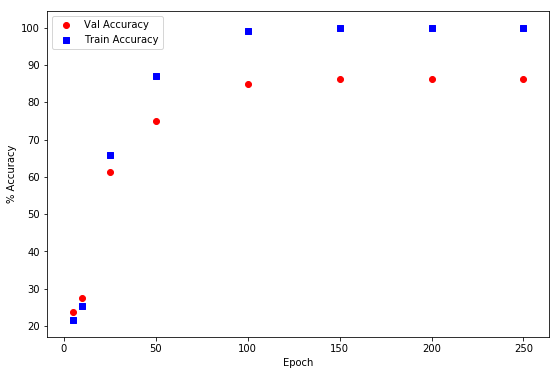

In [11]:
### FIGURE TO SHOW TRAIN AND VAL ERROR ############################

# initialize figure
plt.figure(figsize=(9, 6)) 

# the two scatter grap data sets
data1 = plt.scatter(epochsConsidered, valAccuracy, color='r', marker='o', label='Val Accuracy')
data2 = plt.scatter(epochsConsidered, trainAccuracy, color='b', marker='s', label='Train Accuracy')

# formatting
plt.xlabel('Epoch')
plt.ylabel('% Accuracy')
plt.legend()

# save to file
fig = plt.gcf()
fig.savefig(pathOutput + str(now.strftime("%Y-%m-%d")) + 
            '-Train-Val-Error.png', bbox_inches="tight")

In [12]:
# Check that you can load a previous network
# !!! This loads the saved network into the variable net, overwritting net !!!
# But the last saved net can be reloaded!
#fileToLoad = '2018-01-31Original25_epochs.pth'
#net.load_state_dict(torch.load(os.path.join(pathOutput, 'networks', fileToLoad)))
computeAccuracy(net, valset)

Variable containing:
 20.6144   1.2636   6.6681   1.1280 -13.7587   8.5394  -6.6806 -15.4705
[torch.FloatTensor of size 1x8]

Variable containing:
 22.3715   2.0487   7.6491   2.4302 -14.5360   8.2818  -7.8645 -18.0944
[torch.FloatTensor of size 1x8]

Variable containing:
 23.4677   1.7212   6.6517   0.0262 -14.1417  10.5416  -7.8101 -18.1023
[torch.FloatTensor of size 1x8]

Variable containing:
 26.7674   1.6428   8.0545   0.1492 -15.7353  10.1298  -9.0159 -19.7887
[torch.FloatTensor of size 1x8]

Variable containing:
 21.6668   0.9488   6.8246  -0.8251 -13.6703  10.5490  -6.1519 -16.7661
[torch.FloatTensor of size 1x8]

Variable containing:
 15.1161   0.0631   4.4571   1.0675 -11.2604   6.1726  -2.4832 -10.9976
[torch.FloatTensor of size 1x8]

Variable containing:
 24.3160   3.1526  13.2710   3.9087 -17.3026  15.0920 -11.5646 -25.0504
[torch.FloatTensor of size 1x8]

Variable containing:
 14.5130   2.1449   4.5764   1.2294  -9.4419   2.1180  -2.9972 -11.7032
[torch.FloatTensor of siz

86.25